# GORDOBOB
### Austin Jia, Bill Ma, David Zhang, Gordon Lee

> NOTE: The process and code has been modified for brevity. To see all outputs and programs, please refer to the [full repository](https://github.com/AustinJia-code/Yield-Regression) which will be referenced throughout. This repository was made public after the Kaggle deadline for grading purposes only.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings ('ignore', category = ConvergenceWarning)

In [ ]:
####### DATA PATHS #######
TRAIN_PATH = "./data/in/cattle_data_train.csv"
TEST_PATH = "./data/in/cattle_data_test.csv"
OUT_PATH = "./data/out/"

######## GLOBALS ##########
LABEL_COL = 'Milk_Yield_L'
SEED = int ("".join (str (ord (c)) for c in
            """  __________________
               < GORDOBOB GOT MILK! >
                 ------------------
                         \   ^__^
                          \  (oo)\________
                             (__)\        )\
                                 ||----w-||
                                 ||    ; ||
                      so much milk -> """       )) % (2 ** 32)

<>:8: SyntaxWarning: invalid escape sequence '\ '
<>:8: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_451363/2116958525.py:8: SyntaxWarning: invalid escape sequence '\ '
  """  __________________


# Data Exploration
[/experiments/exploration.ipynb](https://github.com/AustinJia-code/Yield-Regression/blob/main/experiments/exploration.ipynb)

Key Takeaways:
* Milk_Yield_L mean: 15.589155594329181
* Missing Values: Feed_Quantity_lb, Feed_Quantity_kg, Housing_Score
* Typos: "Holstien" -> "Holstein", "Brown_Swiss " -> "Brown_Swiss"
* Out of place negatives: Milk_Yield_L, Rumination_Time_hrs
* Most feature distributions are non-gaussian
* No duplicates
* STRONG seasonal correlation
* STRONG youth correlation

In [ ]:
### BASIC STATS ###
train_data = pd.read_csv (TRAIN_PATH)
data = pd.read_csv (TEST_PATH)

print (train_data[LABEL_COL].mean ())
print (f"Dupes: {data[data.duplicated ()]}")
data.head()
data.info()
data.describe().T

15.589155594329181
Dupes: Empty DataFrame
Columns: [Cattle_ID, Breed, Climate_Zone, Management_System, Age_Months, Weight_kg, Parity, Lactation_Stage, Days_in_Milk, Feed_Type, Feed_Quantity_kg, Feeding_Frequency, Water_Intake_L, Walking_Distance_km, Grazing_Duration_hrs, Rumination_Time_hrs, Resting_Hours, Ambient_Temperature_C, Humidity_percent, Housing_Score, FMD_Vaccine, Brucellosis_Vaccine, HS_Vaccine, BQ_Vaccine, Anthrax_Vaccine, IBR_Vaccine, BVD_Vaccine, Rabies_Vaccine, Previous_Week_Avg_Yield, Body_Condition_Score, Milking_Interval_hrs, Date, Farm_ID, Feed_Quantity_lb, Mastitis]
Index: []

[0 rows x 35 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cattle_ID                40000 non-null  int64  
 1   Breed                    40000 non-null  object 
 2   Climate_Zone             40000 non-null  obj

,count,mean,std,min,25%,50%,75%,max
Cattle_ID,40000.0,20000.500000,11547.149720,1.000000,10000.750000,20000.500000,30000.250000,40000.000000
Age_Months,40000.0,83.263900,34.613224,24.000000,53.000000,83.000000,113.000000,143.000000
Weight_kg,40000.0,501.134588,143.395426,250.000000,377.500000,501.300000,624.500000,750.000000
Parity,40000.0,3.500175,1.704677,1.000000,2.000000,4.000000,5.000000,6.000000
Days_in_Milk,40000.0,183.146600,105.351685,1.000000,92.000000,183.000000,275.000000,364.000000
Feed_Quantity_kg,37985.0,12.015819,3.952974,2.274356,9.316865,12.033033,14.692782,25.469967
Feeding_Frequency,40000.0,3.008675,1.409077,1.000000,2.000000,3.000000,4.000000,5.000000
Water_Intake_L,40000.0,79.892539,14.956080,18.953859,69.822227,79.877772,89.900649,157.259638
Walking_Distance_km,40000.0,4.050308,1.923811,0.500000,2.670000,4.020000,5.360000,12.000000
Grazing_Duration_hrs,40000.0,6.037943,2.867362,1.000000,4.000000,6.000000,8.000000,14.000000


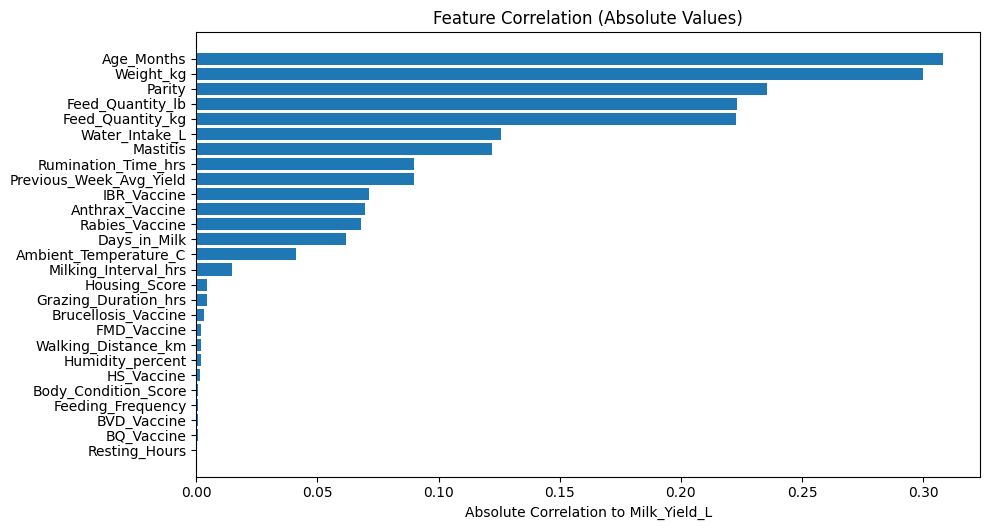

In [53]:
### SIMPLE RAW CORRELATION ###
df = train_data.dropna ().copy ()
df = df.drop (columns = ["Cattle_ID", "Farm_ID"], axis = 1)

y = df["Milk_Yield_L"]
cat_cols = df.select_dtypes (include = ["object", "category"]).columns.tolist ()
df_encoded = pd.get_dummies (df, columns = cat_cols, drop_first = False)
numeric_df = df_encoded.select_dtypes (include = [np.number])
cor = numeric_df.corr ()["Milk_Yield_L"].abs ().sort_values (ascending = False)
cor_df = cor.to_frame (name = "abs_correlation_to_Milk_Yield_L")
cor_df = cor_df.drop ("Milk_Yield_L", errors = "ignore")
cor_df_sorted = cor_df.sort_values ("abs_correlation_to_Milk_Yield_L", ascending = True)

plt.figure (figsize = (10, max (4, len (cor_df_sorted) * 0.2)))
plt.barh (cor_df_sorted.index, cor_df_sorted["abs_correlation_to_Milk_Yield_L"])
plt.xlabel ("Absolute Correlation to Milk_Yield_L")
plt.title ("Feature Correlation (Absolute Values)")
plt.tight_layout ()
plt.show ()

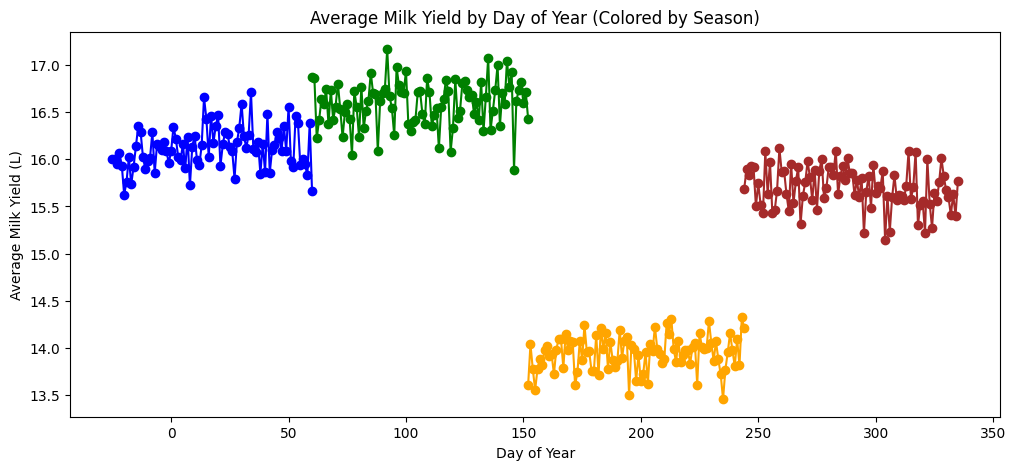

In [54]:
### SEASON EXPLORATION ###
train_data["Date"] = pd.to_datetime (train_data["Date"])
train_data["DayOfYear"] = np.where (train_data["Date"].dt.month == 12,
                                    train_data["Date"].dt.dayofyear - 360,
                                    train_data["Date"].dt.dayofyear)
# Define season mapping
def month_to_season(m):
    if m in [12, 1, 2]:
        return "Winter"
    elif m in [3, 4, 5]:
        return "Spring"
    elif m in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

# Map each row to a season
train_data["Season"] = train_data["Date"].dt.month.apply (month_to_season)

# Compute daily average milk yield, keeping season info
daily_avg = train_data.groupby (["DayOfYear", "Season"])["Milk_Yield_L"].mean ().reset_index ()

# Define colors for seasons
season_colors = {"Winter": "blue",
                 "Spring": "green",
                 "Summer": "orange",
                 "Fall": "brown"}

# Plot each season separately
plt.figure (figsize = (12,5))
for season, color in season_colors.items ():
    season_data = daily_avg[daily_avg["Season"] == season]
    plt.plot (season_data["DayOfYear"], season_data["Milk_Yield_L"],
              marker = "o", color = color, label = season)

plt.xlabel ("Day of Year")
plt.ylabel ("Average Milk Yield (L)")
plt.title ("Average Milk Yield by Day of Year (Colored by Season)")
plt.show ()

> NOTE: The following is some distributions of select features. See [/experiments/plots/feature_analysis/](https://github.com/AustinJia-code/Yield-Regression/blob/main/experiments/plots/feature_analysis/) for all outputs.

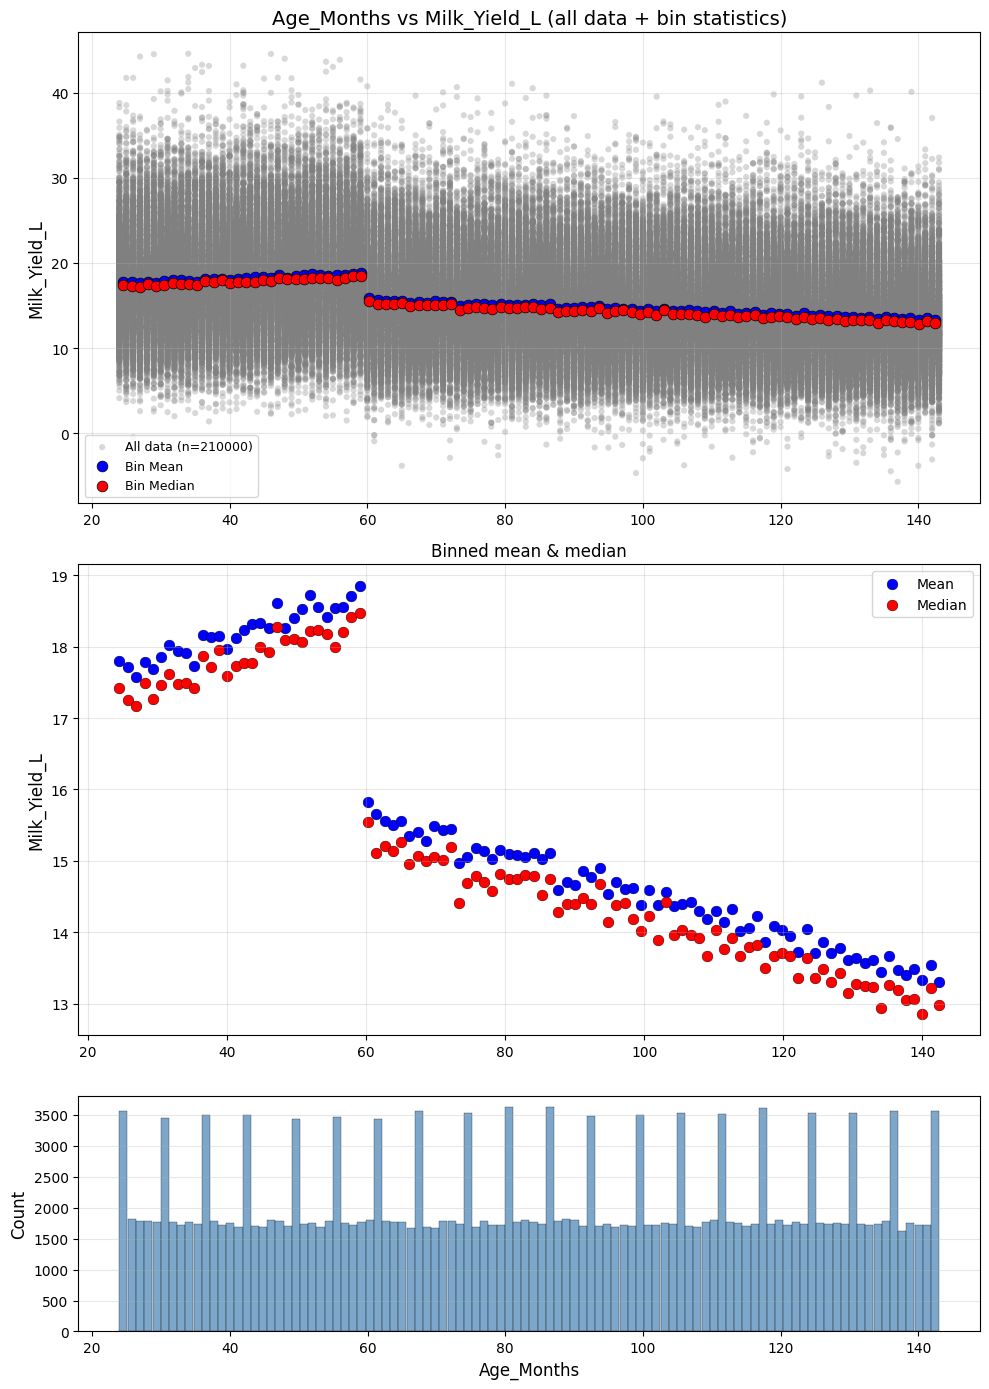

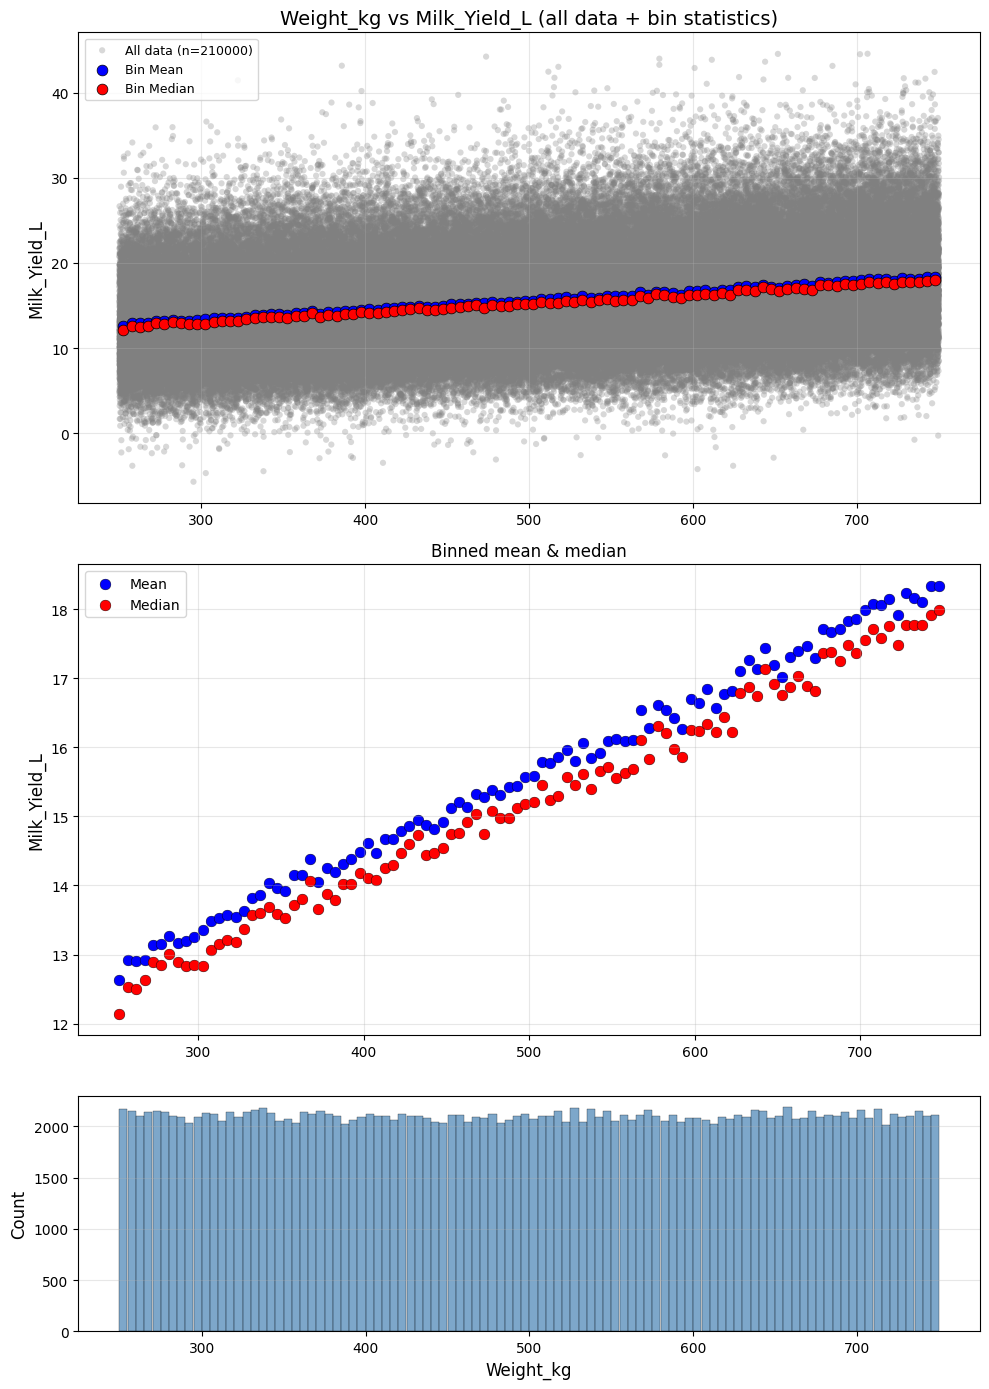

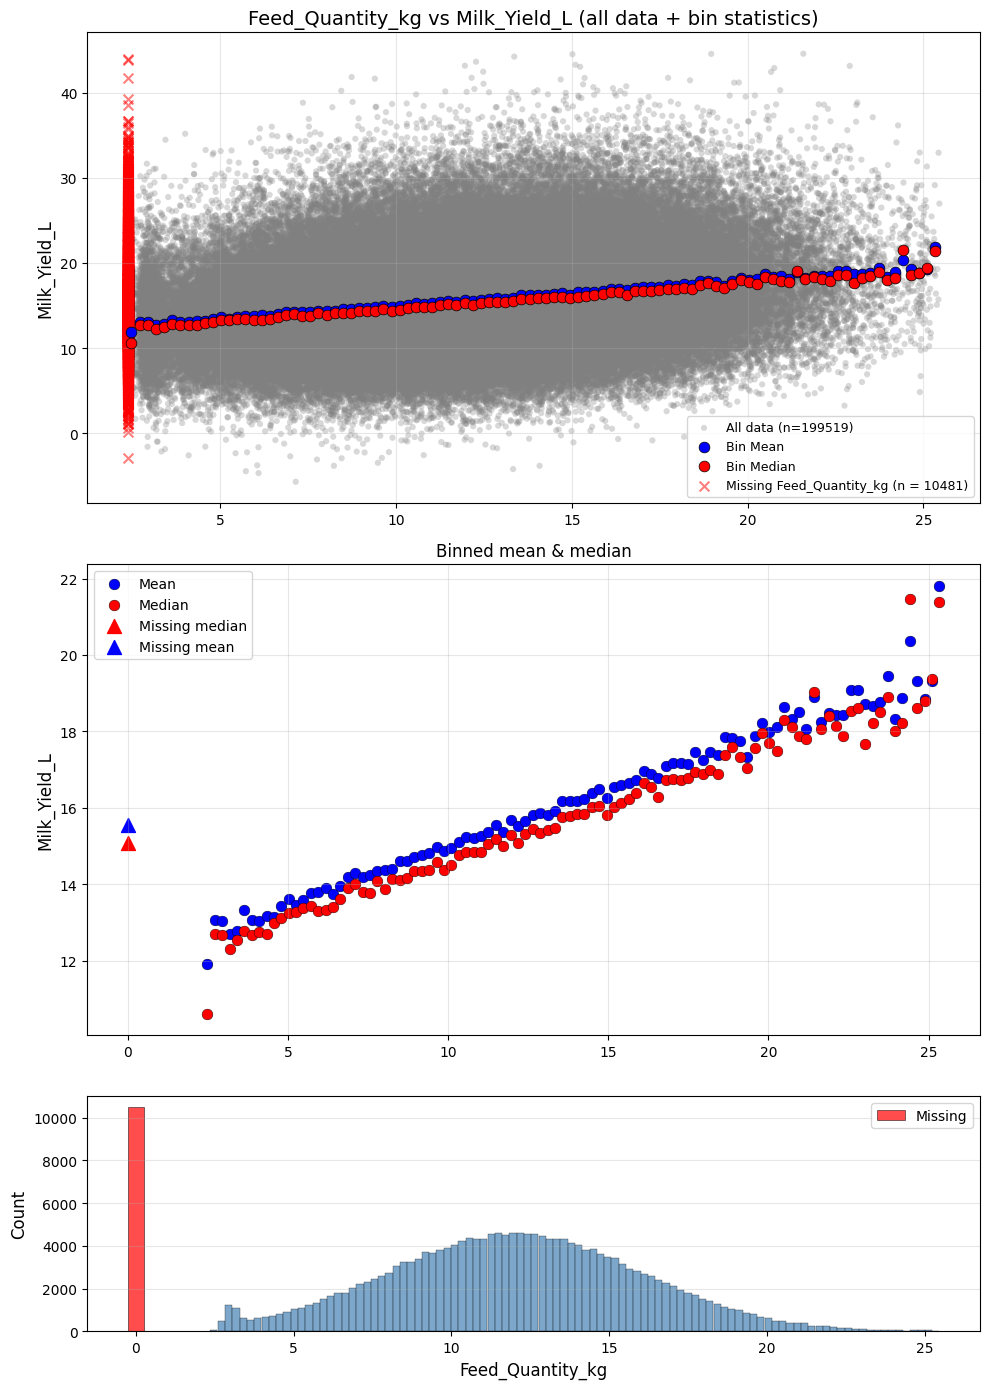

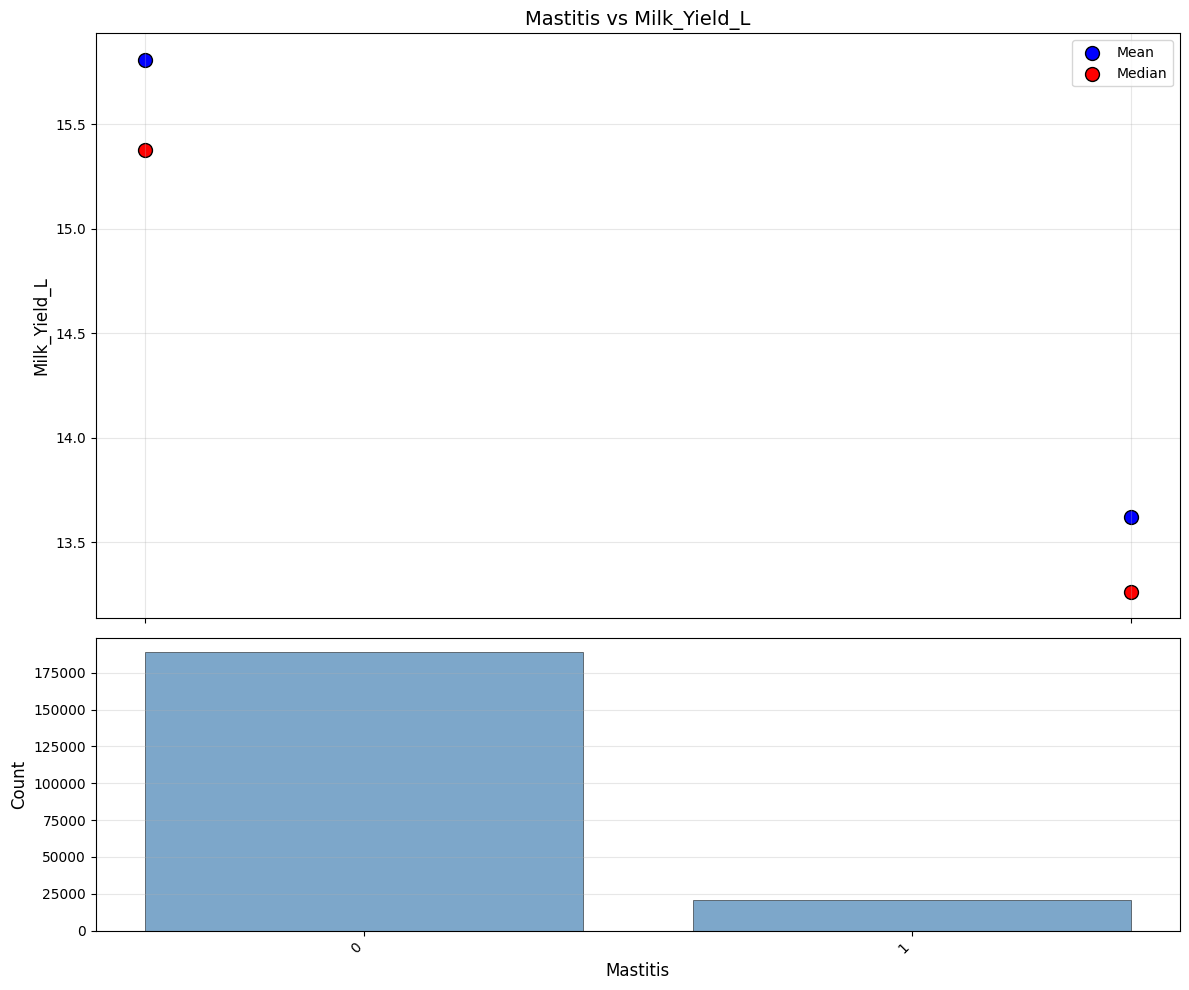

In [ ]:
data = pd.read_csv (TRAIN_PATH)

numeric_cols = ["Age_Months", "Weight_kg", "Feed_Quantity_kg"]
categorical_cols = ["Mastitis"]

# ============================================================================
# NUMERIC FEATURES - Scatter Plots (Mean + Median per bin) + Counts
# ============================================================================
for col in numeric_cols:
    fig, (ax1, ax2, ax3) = plt.subplots (3, 1, figsize = (10, 14),
                                         gridspec_kw = {'height_ratios': [2, 2, 1]})

    # Separate missing vs non-missing
    has_data = data[data[col].notna ()]
    missing_data = data[data[col].isna ()]

    if len (has_data) > 0:
        # Plot all data points (top subplot)
        ax1.scatter (has_data[col], has_data[LABEL_COL], alpha = 0.3,
                    color = 'gray', s=  20, edgecolor = 'none',
                    label = f'All data (n={len(has_data)})')

        # Bin numeric feature into 100 equal-width bins
        has_data = has_data.copy ()
        has_data['x_bin'] = pd.cut (has_data[col], bins = 100)

        # Compute mean & median per bin
        stats = has_data.groupby ('x_bin', observed = True)[LABEL_COL].agg(['mean', 'median', 'count']).reset_index ()

        # Use bin midpoints for x-axis
        stats['x_mid'] = stats['x_bin'].apply (lambda x: x.mid)

        # Plot mean & median on scatter plot (top subplot)
        ax1.scatter (stats['x_mid'], stats['mean'], color = 'blue',
                   label = 'Bin Mean', s = 60, edgecolor='k', linewidth = 0.5, zorder = 5)
        ax1.scatter(stats['x_mid'], stats['median'], color = 'red',
                   label = 'Bin Median', s = 60, edgecolor = 'k', linewidth=0.5, zorder = 5)

        # Plot mean & median (middle subplot)
        ax2.scatter (stats['x_mid'], stats['mean'], color = 'blue',
                    label = 'Mean', s = 60, edgecolor = 'k', linewidth = 0.3)
        ax2.scatter (stats['x_mid'], stats['median'], color = 'red',
                    label = 'Median', s = 60, edgecolor = 'k', linewidth = 0.3)

        # Plot counts (bottom subplot)
        ax3.bar (stats['x_mid'], stats['count'],
                 width = stats['x_bin'].apply (lambda x: x.length).iloc[0] * 0.9,
                 color = 'steelblue', edgecolor = 'k', linewidth = 0.3, alpha = 0.7)

    # Plot missing data
    if len (missing_data) > 0:
        # Missing data on scatter plot
        ax1.scatter ([has_data[col].min ()] * len (missing_data),
                   missing_data[LABEL_COL], marker = 'x',
                   color = 'red', s = 50, alpha = 0.5,
                   label = f'Missing {col} (n = {len(missing_data)})')

        # Missing data stats on bin plot
        ax2.scatter([0], [missing_data[LABEL_COL].median ()], marker = '^',
                   color = 'red', s = 100,
                   label = f'Missing median')
        ax2.scatter([0], [missing_data[LABEL_COL].mean ()], marker = '^',
                   color = 'blue', s = 100,
                   label = f'Missing mean')

        # Add missing count to bottom plot
        ax3.bar ([0], [len (missing_data)], width = 0.5,
                color = 'red', edgecolor = 'k', linewidth = 0.5, alpha = 0.7,
                label = f'Missing')

    # Format top subplot (scatter)
    ax1.set_ylabel (LABEL_COL, fontsize = 12)
    ax1.set_title (f"{col} vs {LABEL_COL} (all data + bin statistics)", fontsize = 14)
    ax1.legend(loc = 'best', fontsize = 9)
    ax1.grid (True, alpha = 0.3)

    # Format middle subplot (bin stats)
    ax2.set_ylabel (LABEL_COL, fontsize = 12)
    ax2.set_title (f"Binned mean & median", fontsize = 12)
    ax2.legend ()
    ax2.grid (True, alpha = 0.3)

    # Format bottom subplot
    ax3.set_xlabel (col, fontsize = 12)
    ax3.set_ylabel ('Count', fontsize = 12)
    ax3.grid (True, alpha = 0.3, axis = 'y')
    if len (missing_data) > 0:
        ax3.legend ()

    plt.tight_layout ()
    plt.show ()

# ============================================================================
# CATEGORICAL FEATURES - Mean & Median Points + Counts
# ============================================================================
for col in categorical_cols:
    # Compute mean, median & count per category
    stats = data.groupby(col, observed=True)[LABEL_COL].agg (['mean', 'median', 'count']).reset_index ()

    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots (2, 1, figsize = (12, 10),
                                     gridspec_kw = {'height_ratios': [2, 1]})

    x_pos = np.arange(len(stats))

    # Plot mean & median (top subplot)
    ax1.scatter (x_pos, stats['mean'], color = 'blue', s = 100,
                label=  'Mean', edgecolor = 'k')
    ax1.scatter (x_pos, stats['median'], color = 'red', s = 100,
                 label = 'Median', edgecolor = 'k')

    # Plot counts (bottom subplot)
    ax2.bar (x_pos, stats['count'], color = 'steelblue',
            edgecolor='k', linewidth = 0.5, alpha = 0.7)

    # Format top subplot
    ax1.set_xticks (x_pos)
    ax1.set_xticklabels ([])  # Remove x labels from top plot
    ax1.set_ylabel (LABEL_COL, fontsize = 12)
    ax1.set_title (f"{col} vs {LABEL_COL}", fontsize = 14)
    ax1.legend ()
    ax1.grid (True, alpha=0.3)

    # Format bottom subplot
    ax2.set_xticks (x_pos)
    ax2.set_xticklabels (stats[col], rotation = 45, ha = 'right')
    ax2.set_xlabel (col, fontsize = 12)
    ax2.set_ylabel ('Count', fontsize = 12)
    ax2.grid (True, alpha = 0.3, axis = 'y')

    plt.tight_layout  ()
    plt.show ()


# Data Cleaning
Key Takeaways:
* Removing out of place negatives hurts results
* Median imputation is best for Feed_Quantity_kg
* StandardScaler is best for all features
* Drop all features with poor correlation to "Milk_Yield_L"
    * We tried adding back features that may be co-correlated with stronger signal features, but it did not help.

> We clean in the same function as preprocessing, see next section!

In [44]:
TARGET_FEATURE =            "Milk_Yield_L"

DROP_FEATURES =            ["Cattle_ID",
                            "Farm_ID",
                            "Feed_Quantity_lb",
                            "Climate_Zone",
                            "Management_System",
                            "Feed_Type",
                            "Feeding_Frequency",
                            "Walking_Distance_km",
                            "Grazing_Duration_hrs",
                            "Rumination_Time_hrs",
                            "Resting_Hours",
                            "Humidity_percent",
                            "BVD_Vaccine",
                            "FMD_Vaccine",
                            "Brucellosis_Vaccine",
                            "HS_Vaccine",
                            "BQ_Vaccine",
                            "Housing_Score",
                            "Body_Condition_Score",
                            "Milking_Interval_hrs",
                            "Breed",
                            "Date",
                            "Season_Winter"]

CATEGORICAL_FEATURES =     ["Season",
                            "Young",
                            "Lactation_Stage",
                            "IBR_Vaccine",
                            "Anthrax_Vaccine",
                            "Rabies_Vaccine"]

STANDARD_SCALED_FEATURES = ["Feed_Quantity_kg",
                            "Water_Intake_L",
                            "Parity",
                            "Ambient_Temperature_C",
                            "Previous_Week_Avg_Yield",
                            "Days_in_Milk",
                            "Age_Months",
                            "Weight_kg",]

# Feature Engineering
Key Takeaways:
* Modify "Age_Months" to have constant slope
* Introduce "Youth" feature to account for discontinuity
* Convert "Date" -> "Season"
* One-Hot encode useful categoricals:
    * "Season", "Young", "Lactation_Stage", "[IBR/Rabies/Anthrax]_Vaccine"
    * Parity performed better scaled numerically
    * Model performed better with "drop_first = True"
* Completely drop poorly correlated/redundant features:
    * "Cattle_ID", "Farm_ID", "Feed_Quantity_lb", "Climate_Zone",    "Management_System", "Feed_Type", "Feeding_Frequency", "Walking_Distance_km",    "Grazing_Duration_hrs", "Rumination_Time_hrs", "Resting_Hours",    "Humidity_percent", "BVD_Vaccine", "FMD_Vaccine", "Brucellosis_Vaccine",    "HS_Vaccine", "BQ_Vaccine", "Housing_Score", "Body_Condition_Score",    "Milking_Interval_hrs", "Breed", "Date", "Season_Winter"
    * "Rumination_Time_hrs" seemed useful, but our model performed better without despite numerous attempts at cleaning 
* Generally we found that a vast majority of the features were far more noisy than signaling, so we went with "less is best"
* Found that multiplicative interaction features were not useful

In [ ]:
def preprocess (
    dtrain, dtest, scaler = None
) -> tuple[pd.DataFrame, pd.DataFrame, StandardScaler]:
    """
    Looking at the date graph, there are very obvious distinctions in yield
    across the different seasons, which are luckily split right into the month
    bins below. Simply convert 'Date' into this 'Season', then drop 'Date' later.
    """
    def month_to_season (m):
        if m in [12, 1, 2]:
            return "Winter"
        elif m in [3, 4, 5]:
            return "Spring"
        elif m in [6, 7, 8]:
            return "Summer"
        else:
            return "Fall"

    months = pd.to_datetime (dtest['Date']).dt.month
    dtest['Season'] = months.apply (month_to_season)

    months = pd.to_datetime (dtrain['Date']).dt.month
    dtrain['Season'] = months.apply (month_to_season)

    """
    The goal of our 'Age_Months' modification is to transform the plot vs. yield
    from this:

    |      .....
    | *****
    |
    |           .....
    |                *****
    |-----------------------

    to this:

    | .....
    |      *****
    |
    |           .....
    |                *****
    |-----------------------
    """
    dtrain['Age_Months'] = np.where(dtrain['Age_Months'] < 60,
                            75 - dtrain['Age_Months'],
                            dtrain['Age_Months'])
    dtest['Age_Months'] = np.where(dtest['Age_Months'] < 60,
                            75 - dtest['Age_Months'],
                            dtest['Age_Months'])

    """
    There is a pretty big discontinuity in the "after" transformation, and
    the best way we found to correct it is to add a term ('Young') for the
    neural net to use as a literal modifier, giving an obvious knob to tune the
    function into place. In theory, it probably shouldn't need this term, but
    empirically it helped a ton!
    """
    dtrain['Young'] = (dtrain['Age_Months'] < 60).astype (int)
    dtest['Young'] = (dtest['Age_Months'] < 60).astype (int)

    """
    A lot of feed was missing, and it is an extremely strong signal so it would
    be wasteful to drop. We tried mean, median, predictive (knn), and random
    imputation before finding that median was best.

    You can see our predictive function here in the Preprocessing block:
    https://github.com/AustinJia-code/Yield-Regression/blob/7d2f8cd541a5de5d6c4fc7a5df5fc676d74503e5/experiments/nnet.ipynb
    """
    median_val = dtrain["Feed_Quantity_kg"].median ()

    dtrain.loc[dtrain["Feed_Quantity_kg"].isna (), "Feed_Quantity_kg"] = median_val
    dtest.loc[dtest["Feed_Quantity_kg"].isna (), "Feed_Quantity_kg"] = median_val

    """
    One-Hot encode categoricals.
    Notably we treated Parity as numerical despite it being discrete. Encoding
    it was worse, likely because 5 dimensions is just too much dimensionality.

    Lactatation_Stage was similarly pseudo-numeric, but performed better as
    a categorical. Either it interacted somehow with another feature (which we
    did not detect in exploration), or three was few enough categories to not bog
    down the feature space.

    'drop_first' performed better as True, again likely because of dimensionality.
    """
    dtrain = pd.get_dummies (dtrain, columns = CATEGORICAL_FEATURES,
                             drop_first = True)
    dtest = pd.get_dummies (dtest, columns = CATEGORICAL_FEATURES,
                            drop_first = True)
    dtrain, dtest = dtrain.align (dtest, join = 'left', axis = 1, fill_value = 0)

    """
    We noticed marginally more correlation in Fall than in Winter (drop_first drops
    Fall by lexicographical ordering), so we swapped Fall back in.
    """
    dtrain["Season_Fall"] = ~(dtrain["Season_Winter"] |
                              dtrain["Season_Summer"] |
                              dtrain["Season_Spring"])

    dtest["Season_Fall"] = ~(dtest["Season_Winter"] |
                             dtest["Season_Summer"] |
                             dtest["Season_Spring"])

    """
    Even on evenly distributed data and features with many outliers, standard
    scaler performed better than min/max and robust, so we just used it for everything.
    """
    if scaler is None:
        scaler = StandardScaler ()
        dtrain[STANDARD_SCALED_FEATURES] = scaler.fit_transform (dtrain[STANDARD_SCALED_FEATURES])
    else:
        dtrain[STANDARD_SCALED_FEATURES] = scaler.transform (dtrain[STANDARD_SCALED_FEATURES])

    dtest[STANDARD_SCALED_FEATURES] = scaler.transform (dtest[STANDARD_SCALED_FEATURES])

    ### DROP ALL THE USELESS FEATURES ###
    dtrain = dtrain.drop (DROP_FEATURES, axis = 1)
    dtest = dtest.drop (DROP_FEATURES, axis = 1)

    ### DONE ###
    return dtrain, dtest, scaler

# Modeling Approach


Brief Summary:

* Tried Random Forest to moderate success, then switched to Neural Net (NN)
* An NN is trained on each of five folds, then a final NN is trained on all the data with the largest max iteration count amongst the five folds
* A Ridge Regressor is fit to predict residuals from the average predictions of the six models
    * Given more time, we would have experimented with an NN stacker using the six predictions as meta-parameters
* Hyperparameters, models used, and general preprocessing is tested beforehand using a properly separated validation set

### PCA + KNN

Note: Due to this being one of our earlier models, this relies on a older version of preprocessing:
[/experiments/preprocessing.py](https://github.com/AustinJia-code/Yield-Regression/blob/main/experiments/preprocessing.py)

Here is the original notebook: [/experiments/pca_knn.ipynb](https://github.com/AustinJia-code/Yield-Regression/blob/main/experiments/pca_knn.ipynb)

Due to changes within preprocessing.py, this section is no longer functional thus the code is commented out. Original outputs are included as markdown

This is a rather simple model that utilizes KNN Regression after Scaling and PCA.

##### Setup

In [ ]:
"""
from preprocessing import clean_data, engineer_data

####### DATA PATHS #######
OUT_PATH = "./data/out/pca_cnn.csv"

########## DEBUG ##########
DEBUG = True

########## MODEL ##########
INNER_CV = 5
OUTER_CV = 5
SCORING = 'neg_root_mean_squared_error'
PCA__N_COMPONENTS = list (range (25, 31, 2))
KNN__N_NEIGHBORS = list (range (50, 251, 50))
"""

##### Init && Pre-Processing + Model

In [ ]:
"""
data = pd.read_csv (TRAIN_PATH)
labels, cleaned_data = clean_data (data)
feature_engineer = FunctionTransformer (engineer_data)

# Pipeline
pipeline = Pipeline ([('f_eng', feature_engineer),
                      ('scaler', StandardScaler ()),
                      ('pca', PCA ()),
                      ('knn', KNeighborsRegressor (weights = 'distance'))])

# Grid Search Double CV
param_grid = {'pca__n_components': PCA__N_COMPONENTS,
              'knn__n_neighbors': KNN__N_NEIGHBORS}

gs = GridSearchCV (estimator = pipeline,
                   param_grid = param_grid,
                   scoring = SCORING,
                   cv = INNER_CV)

nested_scores = cross_val_score (gs,
                                 cleaned_data,
                                 labels,
                                 cv = OUTER_CV,
                                 scoring = SCORING,
                                 n_jobs = -1)

# Evaluate
print (f"Nested RMSE: {-nested_scores.mean ()}")
if (DEBUG):
    print (f"Fold RMSEs: {-nested_scores}")
"""

##### Predict

In [ ]:
"""
# Build final model with all training data
gs.fit (cleaned_data, labels)
print ("Best parameters:", gs.best_params_)
print ("Best inner CV score:", -gs.best_score_)

final_model = gs.best_estimator_

# Predict
test_data = pd.read_csv (TEST_PATH)
_, cleaned_test_data = clean_data (test_data)
predictions = final_model.predict (cleaned_test_data)

# Save
out_data = pd.DataFrame ({'Cattle_ID': np.arange (1, len (predictions) + 1),
                          'Milk_Yield_L': predictions})
out_data.to_csv (OUT_PATH, index = False)
"""

```python
Best parameters: {'knn__n_neighbors': 150, 'pca__n_components': 29}
Best inner CV score: 5.162206442609472
```

Looking at the RMSEs, it is rather apparent that the this KNN Regession model performs rather poorly compared to later models we attempt.

### Random Forests

Original notebook: [/experiments/random_forest.ipynb](https://github.com/AustinJia-code/Yield-Regression/tree/main/experiments)

While the model remained the same throughout, we will share some of the different preprocessing changes we made in [/experiments/preprocessing.py](https://github.com/AustinJia-code/Yield-Regression/blob/main/experiments/preprocessing.py) that led to improved results.

We mainly experimented with what features were dropped:
* Rumination worsened results when used despite seeming useful in exploration
    * This was likely because with a good amount of negatives (which is impossible for rumination).
    * Oddly, the distribution seems fairly normal even with the negatives, so this is just a confusing feature overall that we should all forget about...
* Majority of the features we determined during this phase were reflected by the features we selected above for feature selection/feature engineering, alsu used by our neural net models.
* One final notable change was clipping negative yields - we later undid this for neural nets.

##### Setup

This was the original full param_grid:
```python
N_ESTIMATORS = [100, 200, 300, 1000]
MAX_DEPTH = [10, 15, 20, 25, 30]
MIN_SAMPLES_SPLIT = [10, 12, 15]
MIN_SAMPLES_LEAF = [3, 5, 8] 
```

Unfortunately, we no longer have the actual results anymore (and it will take a decade for us to run everything again. Thus, we simply performed this process manually for Neural Nets later).

Some results we still have from earlier runs, using a quick and dirty 2CV for speed: 

```python
N_ESTIMATORS = [200]
MAX_DEPTH = [12]
MIN_SAMPLES_SPLIT = [5]
MIN_SAMPLES_LEAF = [2]
Nested RMSE: 4.33659974819663
Fold RMSEs: [4.33820986 4.33498964] 

N_ESTIMATORS = [300]
MAX_DEPTH = [15]
MIN_SAMPLES_SPLIT = [10] 
MIN_SAMPLES_LEAF = [5]
Nested RMSE: 4.281999444790026
Fold RMSEs: [4.28378338 4.28021551] 
```

The below version is a demo with a much smaller grid that closely reflect the final paramters selected. 

In [ ]:
from preprocessing import clean_data, engineer_data

RF_OUT = OUT_PATH + "random_forest.csv"

########## DEBUG ##########
DEBUG = True

########## MODEL ##########
INNER_CV = 2
OUTER_CV = 2
SCORING = 'neg_root_mean_squared_error'
MAX_FEATURES = 'sqrt'
RANDOM_STATE = 0

# Param Grid
N_ESTIMATORS = [300, 1000]
MAX_DEPTH = [15, 25]
MIN_SAMPLES_SPLIT = [10]
MIN_SAMPLES_LEAF = [5]

##### Init && Pre-Processing + Model

In [ ]:
data = pd.read_csv (TRAIN_PATH)
labels, cleaned_data = clean_data (data)
feature_engineer = FunctionTransformer (engineer_data)

# Pipeline
pipeline = Pipeline ([('f_eng', feature_engineer),
                      ('rf', RandomForestRegressor (max_features = MAX_FEATURES,
                                                    random_state = RANDOM_STATE,
                                                    n_jobs = 1))])

# Grid Search Double CV
param_grid = {'rf__n_estimators': N_ESTIMATORS,
              'rf__max_depth': MAX_DEPTH,
              'rf__min_samples_split': MIN_SAMPLES_SPLIT,
              'rf__min_samples_leaf': MIN_SAMPLES_LEAF,}

gs = GridSearchCV (estimator = pipeline,
                   param_grid = param_grid,
                   scoring = SCORING,
                   cv = INNER_CV,
                   n_jobs = 1)

nested_scores = cross_val_score (gs,
                                 cleaned_data,
                                 labels,
                                 cv = OUTER_CV,
                                 scoring = SCORING,
                                 n_jobs = 1)

# Evaluate
if (DEBUG):
    print (f"Nested RMSE: {-nested_scores.mean ()}")
    print (f"Fold RMSEs: {-nested_scores}")

Nested RMSE: 4.177642342116636
Fold RMSEs: [4.17834517 4.17693951]


In [ ]:
# Build final model with all training data
gs.fit (cleaned_data, labels)
if (DEBUG):
    print ("Best parameters:", gs.best_params_)
    print ("Best inner CV score:", -gs.best_score_)

final_model = gs.best_estimator_

# Predict
test_data = pd.read_csv (TEST_PATH)
_, cleaned_test_data = clean_data (test_data)

predictions = final_model.predict (cleaned_test_data)

# Save
out_data = pd.DataFrame ({'Cattle_ID': np.arange (1, len (predictions) + 1),
                          'Milk_Yield_L': predictions})
out_data.to_csv (RF_OUT, index = False)

Best parameters: {'rf__max_depth': 25, 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 1000}
Best inner CV score: 4.177642342116636


While we were trying out Random Forests, we were also exploring neural nets. Even with the best hyperparameters we found using GridSearch, the RMSE of the model was still rather high compared to neural nets. Thus we decided to focus our energy on neural nets.

### Single Neural Nets

While all of these models use the preprocessing function as defined above, it is important to note that the preprocessing function has evolved from when we were originally starting out with Neural Nets.


##### Setup


In [ ]:
NN_OUT = OUT_PATH + "nnet.csv"

train_data = pd.read_csv (TRAIN_PATH)

X_train, X_test, y_train, y_test = train_test_split (
    train_data.drop (TARGET_FEATURE, axis = 1),
    train_data[TARGET_FEATURE], test_size = 0.2, random_state = 0)

X_train, X_test, scaler = preprocess (X_train, X_test)

In [ ]:
# RMSE at each checkpoint
train_rmse_list = []
test_rmse_list = []

total_iterations = 0
iterations_per_step = 10

"""
Hyperparameters were tuned manually after a very broad gridsearch pass
hidden_layer_sizes: (128, 96, 64), (200, 200), (100, 100, 100), many others
activation: "ReLU"
learning_rate_init: 0.0003, 0.00005, 0.0005
"""
model_template = MLPRegressor (hidden_layer_sizes = (110, 110, 110),
                               activation = "tanh",
                               learning_rate_init = 0.00003,
                               learning_rate = "adaptive",
                               early_stopping = False,
                               n_iter_no_change = 20,
                               verbose = False,
                               warm_start = True,
                               max_iter = iterations_per_step,
                               random_state = 1)

##### Evaluation

In [ ]:
model = clone (model_template)
prev_rmse = float ('inf')
test_rmse = 0
TOLERANCE = 0.00005
print (model)

"""
We wanted to see training outputs as the model ran, which is only possible with
a low max_iter and warm_start = True. We continued training until we reached a
test RMSE minima.
"""
while (test_rmse + TOLERANCE < prev_rmse):
    if test_rmse > 0:
        prev_rmse = test_rmse
    model.fit (X_train, y_train)

    # Compute RMSE
    y_train_pred = model.predict (X_train)
    y_test_pred = model.predict (X_test)
    train_rmse = np.sqrt (mean_squared_error (y_train, y_train_pred))
    test_rmse = np.sqrt (mean_squared_error (y_test, y_test_pred))

    train_rmse_list.append (train_rmse)
    test_rmse_list.append (test_rmse)

    total_iterations += iterations_per_step
    print (f"Iteration {total_iterations}: Train RMSE={train_rmse:.5f}, Test RMSE={test_rmse:.5f}")

print ("Termination Condition Reached:")
print (f"Prev: {prev_rmse}")
print (f"Last: {test_rmse}", flush = True)

MLPRegressor(activation='tanh', hidden_layer_sizes=(110, 110, 110),
             learning_rate='adaptive', learning_rate_init=3e-05, max_iter=10,
             n_iter_no_change=20, random_state=1, warm_start=True)
Iteration 10: Train RMSE=4.15346, Test RMSE=4.15077
Iteration 20: Train RMSE=4.11861, Test RMSE=4.11484
Iteration 30: Train RMSE=4.11126, Test RMSE=4.10816
Iteration 40: Train RMSE=4.10815, Test RMSE=4.10582
Iteration 50: Train RMSE=4.10645, Test RMSE=4.10484
Iteration 60: Train RMSE=4.10534, Test RMSE=4.10437
Iteration 70: Train RMSE=4.10451, Test RMSE=4.10412
Iteration 80: Train RMSE=4.10383, Test RMSE=4.10397
Iteration 90: Train RMSE=4.10324, Test RMSE=4.10388
Iteration 100: Train RMSE=4.10271, Test RMSE=4.10383
Iteration 110: Train RMSE=4.10222, Test RMSE=4.10381
Termination Condition Reached:
Prev: 4.103829164840081
Last: 4.1038050543927005


##### Final Model + Prediction

In [ ]:
# Build final model
train_data = pd.read_csv (TRAIN_PATH)
test_data = pd.read_csv (TEST_PATH)

X_train = train_data.drop (TARGET_FEATURE, axis = 1)
y_train = train_data[TARGET_FEATURE]

X_test = test_data
X_train, X_test, scaler = preprocess (X_train, X_test)

model = clone (model_template)
model.max_iter = total_iterations
model.fit (X_train, y_train)

# Final Predictions
y_pred = model.predict (X_test)

"""
We used training mean as a rough heuristic of if our final output was sensible.
"""
print (f"Training mean: {y_train.mean ()}")
print (f"Predicted mean: {y_pred.mean ()}")
out_data = pd.DataFrame ({'Cattle_ID': np.arange (1, len (y_pred) + 1),
                          'Milk_Yield_L': y_pred})
out_data.to_csv (NN_OUT, index = False)

Training mean: 15.58915559432918
Predicted mean: 15.582484570480382


The following is a list of different things we tried and their results (only differences from what is above will be noted):

Original attempt:  
1. Train RMSE: 4.219917166972286 / Test RMSE: 4.2705374144863875  
For this attempt, we had minimal cleaning, feature selection, and feature engineering. Thus, most features were still included and only obvious cleaning was applied, such as correcting typos for breed.  
Additionally, `hidden_layer_sizes = (128, 32)` and we trained exactly 100 iterations with `early_stopping` still enabled (this was disabled for the final version above as we now manually handle overfitting).

Other attempts:

2. Train RMSE: 4.105999147942853 / Test RMSE: 4.113032609190233  
This model more closely reflected the model we have shown above. In this case, the majority of the features that we deemed unnecessary were dropped in the preprocessing block. Additionally, we compared feed quantity (kg) with feed quantity (lb) to ensure that if we were to convert lb to kg, the kg value was still accurate. For this neural net, we used `hidden_layer_sizes = (128, 96, 64)` (which was the best until we found `(110, 110, 110)` later on) and ran the full 300 iterations (epochs) (`early_stopping` was disabled).

3. Train RMSE: 4.0988704662942075 / Test RMSE: 4.110341266907565  
Here, we attempted to address feed quantity properly. Unfortunately, when feed quantity (kg) was null, feed quantity (lb) was also null, and feed quantity (lb) was less precise. From here on out, we simply imputed feed quantity (kg) with the median feed quantity for any missing fields. Additionally, the number of total iterations (epochs) was lowered to 200.

4. Train RMSE: 4.099602238400221 / Test RMSE: 4.109120932633724  
The main difference for this attempt was `hidden_layer_sizes = (100, 100, 100)` instead of `(128, 96, 64)`.

5. After attempting numerous neural nets including and excluding `Breed` and `Milking_Interval_Hours`, we noticed improvement when excluding those features. Additionally, after switching to `hidden_layer_sizes = (110, 110, 110)`, we noticed a minor improvement on Kaggle.

Special Note: We also tried different optimizers including `sgd` and activation functions including `relu`, and none performed better. Due to the time-intensive nature of a full hyperparameter search, hyperparameters were mostly tuned manually.

After trying a single neural net, we realized that our validation RMSE was still differing from Kaggle by quite a bit. This is likely because of the higher chance of variance since we don't get to train on 20% of the data when calculating the error. Thus, we wanted to attempt to ensemble *k* neural nets obtained from K-fold cross-validation.

#### Side Quest: Single Neural Net Tensor Flow

This is a summarized version of our attempt to use TensorFlow. This was orginally run on colab and the run was terminated. We quickly resorted back to scikit-learn. Thus this code is purely experimental and the full code is not presented. We do not expect this code to be fully runnable and thus is commented out.

We also tried Pytouch without success...

In [ ]:
"""
def build_model_for_tuner(hp):

    # --- Define Hyperparameters to Tune ---

    # Tune Layer Widths
    width_1 = hp.Int('width_1', min_value=64, max_value=320, step=32)
    width_2 = hp.Int('width_2', min_value=32, max_value=192, step=32)
    width_3 = hp.Int('width_3', min_value=16, max_value=96, step=16)

    # Tune Regularization
    l2_reg = hp.Choice('l2_reg', values=[0.0, 1e-6, 1e-5, 1e-4])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.4, step=0.1)

    # Tune Learning Rate
    learning_rate = hp.Choice('learning_rate', values=[5e-4, 3e-4, 1e-4, 5e-5])

    # Tune Activation
    # Note: This was before we realized we were limited on which activation function we were permitted to use
    activation = hp.Choice('activation', values=['swish', 'relu', 'gelu'])

    # --- Build the Model ---

    reg = keras.regularizers.l2(l2_reg) if l2_reg > 0 else None

    model = keras.Sequential([
        keras.layers.Input(shape=(n_features,)),

        # Layer 1
        keras.layers.Dense(width_1, kernel_regularizer=reg),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation),
        keras.layers.Dropout(dropout_rate),

        # Layer 2
        keras.layers.Dense(width_2, kernel_regularizer=reg),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation),
        keras.layers.Dropout(dropout_rate),

        # Layer 3
        keras.layers.Dense(width_3, kernel_regularizer=reg),
        keras.layers.BatchNormalization(),
        keras.layers.Activation(activation),
        keras.layers.Dropout(dropout_rate),

        # Output
        keras.layers.Dense(1, activation="linear")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")],
    )

    return model
    """

After 2 hours and 20 minutes (on a high performing GPU on colab), the best RMSE so far was 4.143749713897705 with the best hyperparameters being:
```python
Best Value So Far |Hyperparameter
224               |width_1
96                |width_2
32                |width_3
0                 |l2_reg
0.1               |dropout_rate
0.0005            |learning_rate
relu              |activation
34                |tuner/epochs
12                |tuner/initial_epoch
4                 |tuner/bracket
3                 |tuner/round
```
Given that the RMSE was much worse than what we were seeing with scikit-learn, and that we really didn't fully understand Tensor Flow, we quickly abandoned this approach

### Stacked/Ensembled Neural Nets:

See our testbed here: [/experiments/nnet_ensemble_testbed.ipynb](https://github.com/AustinJia-code/Yield-Regression/blob/main/experiments/nnet_ensemble_testbed.ipynb)


Since this is reflective of the final model, we will list some different things we tried along the way.

1\. Average fold RMSEs: 4.115750143411139\
This was our baseline ensemble model. This ensemble consisted of the mean of 5 neural nets that we obtained from 5-fold cross validation + 1 neural net trained on the full data. 

2\. Average fold RMSEs: 4.110228997340087 \
The only additional data cleaning from our baseline model was creating a new feature called `young`. This is because we noticed a rather large dropoff in milk yield after the age of the cow exceeds 60 months. By creating this feature, we saw noticible improvements in the RMSE.

3\. Average fold RMSEs: 4.109235481492294 \
After noticing fairly good improvment after creating the `young` feature, we decided it may help if we linearized the `Age_Months`. 
Thus we added the following preprocessing:
```python
    dtrain['Age_Months'] = np.where(dtrain['Age_Months'] < 60,
                            75 - dtrain['Age_Months'],
                            dtrain['Age_Months'])
    dtest['Age_Months'] = np.where(dtest['Age_Months'] < 60,
                            75 - dtest['Age_Months'],
                            dtest['Age_Months'])
```
4\. Attempts to linearize `Days_In_Milk`: \
Average fold RMSEs: 4.109832535879088 (adding the squared and cubed term) 
```python
    ### POLYNOMIAL FEATURES FOR Days_in_Milk ###
    dtrain["Days_in_Milk_sq"] = dtrain["Days_in_Milk"] ** 2
    dtest["Days_in_Milk_sq"] = dtest["Days_in_Milk"] ** 2

    dtrain["Days_in_Milk_cu"] = dtrain["Days_in_Milk"] ** 3
    dtest["Days_in_Milk_cu"] = dtest["Days_in_Milk"] ** 3
```

Average fold RMSEs: 4.109284898196958 (only including cubed term)
```python
    ### POLYNOMIAL FEATURES FOR Days_in_Milk ###
    dtrain["Days_in_Milk_cu"] = dtrain["Days_in_Milk"] ** 3
    dtest["Days_in_Milk_cu"] = dtest["Days_in_Milk"] ** 3

    # Drop original Days_in_Milk
    dtrain = dtrain.drop(columns=["Days_in_Milk"])
    dtest = dtest.drop(columns=["Days_in_Milk"])
```
Neither of these performed better than 3

6\. Below was our final experiment and our final model. 

It ensembles 5 neural nets trained on separate folds as well as a final model trained on all the folds using the largest training iterations found amongst the inital 5 neural nets. 

It further trains a ridge regressor to adjust the final prediction instead of taking just the raw mean.

The only new code added here was stacking, which will be further discussed in our full model section.
So some results to motivate our use of this model:

```python
============================================================
RESIDUAL STACKING - COMPARISON
============================================================

APPROACH 1: Residual model trained on 5 K-Fold models only
------------------------------------------------------------
5-Fold Model weights:
  Fold 1: Val RMSE=4.12940
  Fold 2: Val RMSE=4.12844
  Fold 3: Val RMSE=4.12985
  Fold 4: Val RMSE=4.12714
  Fold 5: Val RMSE=4.12678

Training residuals (5-fold) - Mean: 0.05266, Std: 4.09701
Validation residual predictions (5-fold) - Mean: 0.05269, Std: 0.02266

Testing dampening factors (5-fold):
  Dampening 0.3: RMSE = 4.12658
  Dampening 0.5: RMSE = 4.12650
  Dampening 0.7: RMSE = 4.12645
  Dampening 1.0: RMSE = 4.12644

Best dampening factor (5-fold): 1.0

============================================================
APPROACH 2: Residual model trained on all 6 models (5 folds + full)
------------------------------------------------------------
All 6 model weights:
  Fold 1: Val RMSE=4.12940
  Fold 2: Val RMSE=4.12844
  Fold 3: Val RMSE=4.12985
  Fold 4: Val RMSE=4.12714
  Fold 5: Val RMSE=4.12678
  Full 6: Val RMSE=4.12890

Training residuals (6 models) - Mean: 0.06562, Std: 4.09676
Validation residual predictions (6 models) - Mean: 0.06566, Std: 0.02095

Testing dampening factors (6 models):
  Dampening 0.3: RMSE = 4.12663
  Dampening 0.5: RMSE = 4.12650
  Dampening 0.7: RMSE = 4.12642
  Dampening 1.0: RMSE = 4.12639

Best dampening factor (6 models): 1.0

============================================================
RESIDUAL STACKING COMPARISON
============================================================
5-Fold Weighted Ensemble:              4.12676
5-Fold + Residual Stacking:            4.12644
6-Model Weighted Ensemble:             4.12691
6-Model + Residual Stacking:           4.12639

============================================================
IMPROVEMENTS FROM RESIDUAL STACKING
============================================================
5-Fold approach improvement:           0.00032
6-Model approach improvement:          0.00052
```

The most important output is the second to last section, which shows that the 6-model residual stacker was the best performer.

#### Side Quest : Bagging (Using Out of Bag (OOB) Validation)

We figured we could try this just for fun. Didn't actually submit to kaggle so...

In [ ]:
model_template = MLPRegressor (hidden_layer_sizes = (110, 110, 110),
                               activation = "tanh",
                               learning_rate_init = 0.00003,
                               learning_rate = "adaptive",
                               early_stopping = False,
                               n_iter_no_change = 20,
                               verbose = False,
                               warm_start = False,
                               max_iter = 100,
                               random_state = SEED)

In [ ]:
from sklearn.ensemble import BaggingRegressor

train_data = pd.read_csv (TRAIN_PATH)
X_train = train_data.drop (TARGET_FEATURE, axis = 1)
Y_train = train_data[TARGET_FEATURE]
X_train_proc, _, scaler = preprocess(X_train, None)

bag_model = BaggingRegressor(
    estimator=model_template,
    n_estimators=10,
    bootstrap=True,
    max_features=1.0,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED
)

print("Training bagged MLP...")
bag_model.fit(X_train_proc, Y_train)

oob_pred = bag_model.oob_prediction_
oob_rmse = np.sqrt(mean_squared_error(Y_train, oob_pred))
print(f"OOB RMSE (bagged MLP): {oob_rmse:.5f}")

train_pred = bag_model.predict(X_train_proc)
train_rmse = np.sqrt(mean_squared_error(Y_train, train_pred))
print(f"Train RMSE (bagged MLP): {train_rmse:.5f}")

Output from Colab:

```python
OOB RMSE (bagged MLP): 4.41551
Train RMSE (bagged MLP): 4.09910
```

We realized that using the Out-of-Bag (OOB) RMSE made it difficult to compare against the ensembled neural nets used in our final model. With only a limited number of submissions remaining, we decided to abandon this approach, as OOB RMSE tends to be an overestimate of the true error.

# Final Model
[/experiments/nnet_fold_full_ensemble.ipynb](https://github.com/AustinJia-code/Yield-Regression/blob/main/experiments/nnet_fold_full_ensemble.ipynb)

In [ ]:
FINAL_OUT = OUT_PATH + "nnet_fold_full_ensemble.csv"

# Define our base NN
ITERATIONS_PER_STEP = 10
model_template = MLPRegressor (hidden_layer_sizes = (110, 110, 110),
                               activation = "tanh",
                               learning_rate_init = 0.00003,
                               learning_rate = "adaptive",
                               early_stopping = False,
                               n_iter_no_change = 20,
                               verbose = False,
                               warm_start = True,
                               max_iter = ITERATIONS_PER_STEP,
                               random_state = SEED)

### Training Folds

In [59]:
# Params
TOLERANCE = 0.00005

train_data = pd.read_csv (TRAIN_PATH)
X_train = train_data.drop (TARGET_FEATURE, axis = 1)
Y_train = train_data[TARGET_FEATURE]

kf = KFold (n_splits = 5, shuffle = True, random_state = SEED)
fold_models = []
fold_scalers = []
fold_iterations = []
fold_val_rmses = []

# Train all folds, these will be ensembled
for fold_idx, (train_idx, val_idx) in enumerate (kf.split (X_train)):
    print (f"\nTraining fold {fold_idx + 1}/5...")

    # Split fold into train/validation
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = Y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = Y_train.iloc[val_idx]

    # Preprocess fold data
    X_fold_train_proc, X_fold_val_proc, fold_scaler = \
                                            preprocess (X_fold_train.copy (),
                                                        X_fold_val.copy ())

    # Train until test RMSE stops improving meaningfully
    fold_model = clone (model_template)
    prev_fold_rmse = float ('inf')
    fold_val_rmse = 0
    fold_iters = 0

    while fold_val_rmse + TOLERANCE < prev_fold_rmse:
        if fold_val_rmse > 0:
            prev_fold_rmse = fold_val_rmse

        fold_model.fit (X_fold_train_proc, y_fold_train)

        y_fold_val_pred = fold_model.predict (X_fold_val_proc)
        fold_val_rmse = np.sqrt (mean_squared_error (y_fold_val, y_fold_val_pred))

        fold_iters += ITERATIONS_PER_STEP
        print (f"  Iteration {fold_iters}: Val RMSE = {fold_val_rmse:.5f}")

    fold_val_rmses.append (fold_val_rmse)

    print (f"  Optimal iterations for fold {fold_idx + 1}: {fold_iters}")
    fold_iterations.append (fold_iters)
    fold_models.append (fold_model)
    fold_scalers.append (fold_scaler)

print (f"\nAverage fold RMSEs: {sum (fold_val_rmses) / len (fold_val_rmses)}")


Training fold 1/5...
  Iteration 10: Val RMSE = 4.18126
  Iteration 20: Val RMSE = 4.14307
  Iteration 30: Val RMSE = 4.13643
  Iteration 40: Val RMSE = 4.13386
  Iteration 50: Val RMSE = 4.13264
  Iteration 60: Val RMSE = 4.13203
  Iteration 70: Val RMSE = 4.13171
  Iteration 80: Val RMSE = 4.13157
  Iteration 90: Val RMSE = 4.13151
  Iteration 100: Val RMSE = 4.13150
  Optimal iterations for fold 1: 100

Training fold 2/5...
  Iteration 10: Val RMSE = 4.15245
  Iteration 20: Val RMSE = 4.11878
  Iteration 30: Val RMSE = 4.11342
  Iteration 40: Val RMSE = 4.11157
  Iteration 50: Val RMSE = 4.11073
  Iteration 60: Val RMSE = 4.11035
  Iteration 70: Val RMSE = 4.11021
  Iteration 80: Val RMSE = 4.11019
  Optimal iterations for fold 2: 80

Training fold 3/5...
  Iteration 10: Val RMSE = 4.15988
  Iteration 20: Val RMSE = 4.12511
  Iteration 30: Val RMSE = 4.11834
  Iteration 40: Val RMSE = 4.11557
  Iteration 50: Val RMSE = 4.11418
  Iteration 60: Val RMSE = 4.11342
  Iteration 70: Val 

### Build "full" model (all training data, no folds)

In [ ]:

X_test = pd.read_csv (TEST_PATH)
X_train_full, X_test_full, scaler = preprocess (X_train.copy (), X_test.copy ())

model = clone (model_template)
"""
No perfect way to choose max iterations, we simply chose the largest of the fold iterations.
"""
model.max_iter = max (fold_iterations)
model.fit (X_train_full, Y_train)

fold_models.append (model)
fold_scalers.append (scaler)

### Mean Ensemble

For this ensemble, the prediction for each test record is the the mean of the predictions for each neural net in the ensemble (1 from each fold (5) + 1 full model)

In [61]:
# Ensemble predictions (mean)
print ("Generating ensemble predictions...")
ensemble_preds = []
X_train = pd.read_csv (TRAIN_PATH).drop (TARGET_FEATURE, axis = 1)
X_test = pd.read_csv (TEST_PATH)

for fold_model, fold_scaler in zip (fold_models, fold_scalers):
    temp, X_test_proc, _ = preprocess (X_train.copy (),
                                    X_test.copy (),
                                    scaler = fold_scaler)
    fold_pred = fold_model.predict (X_test_proc)
    ensemble_preds.append (fold_pred)

    train_pred = fold_model.predict (temp)
    rmse = np.sqrt (mean_squared_error (train_pred, Y_train))
    print (f"Train RMSE: {rmse}")

y_pred_ensemble = np.mean (ensemble_preds, axis = 0)

print (f"Ensemble pred mean: {y_pred_ensemble.mean ():.5f}")
print (f"Training label mean: {Y_train.mean ():.5f}")

Generating ensemble predictions...
Train RMSE: 4.103716970144752
Train RMSE: 4.103671981067284
Train RMSE: 4.1027693484712575
Train RMSE: 4.104115224142294
Train RMSE: 4.103478323646582
Train RMSE: 4.101801981582395
Ensemble pred mean: 15.62390
Training label mean: 15.58916


### Residual Correction Model

Further apply corrections based on the residuals.

In [ ]:
# Residual Stacker (correction term)
print ("\n" + "="*60)
print ("RESIDUAL STACKING ON TEST SET")
print ("="*60)

# Get training predictions from all models for residual calculation
train_preds_for_residuals = []
X_train_full = pd.read_csv (TRAIN_PATH).drop (TARGET_FEATURE, axis = 1)
Y_train_full = pd.read_csv (TRAIN_PATH)[TARGET_FEATURE]

for fold_model, fold_scaler in zip (fold_models, fold_scalers):
    X_train_proc_temp, _, _ = preprocess (X_train_full.copy (),
                                          X_train_full.copy (),
                                          scaler = fold_scaler)
    train_pred = fold_model.predict (X_train_proc_temp)
    train_preds_for_residuals.append (train_pred)

# Calculate weighted (weights = 1) ensemble predictions on training data
y_train_pred_weighted = np.average (train_preds_for_residuals, axis = 0)
residuals = Y_train_full.values - y_train_pred_weighted

print (f"\nTraining residuals - Mean: {residuals.mean ():.5f}, Std: {residuals.std ():.5f}")

# Train residual correction model
residual_model = Ridge (alpha = 10.0, random_state = SEED)
X_train_proc_for_residuals, _, _ = preprocess (X_train_full.copy (),
                                               X_train_full.copy (),
                                               scaler = fold_scalers[-1])  # Use full model scaler

residual_model.fit (X_train_proc_for_residuals, residuals)

# Predict and add residual corrections
residual_correction = residual_model.predict (X_test_proc)
# 1.45 from matching test mean to training mean (unproven heuristic)
# 1.0 performed the best on the validation set however because we were making last minute changes
# to squeeze out performance we ended with using 1.45.
y_test_pred_stacked = y_pred_ensemble + 1.45 * residual_correction

print (f"\nTest predictions:")
print (f"  Weighted ensemble mean: {y_pred_ensemble.mean ():.5f}")
print (f"  Residual correction mean: {residual_correction.mean ():.5f}")
print (f"  Final stacked mean: {y_test_pred_stacked.mean ():.5f}")
print (f"  Training label mean: {Y_train_full.mean ():.5f}")

# Save stacked predictions
out_data_stacked = pd.DataFrame ({'Cattle_ID': np.arange (1, len (y_test_pred_stacked) + 1),
                                  'Milk_Yield_L': y_test_pred_stacked})
out_data_stacked.to_csv (FINAL_OUT, index = False)
print (f"\nStacked predictions saved to: {FINAL_OUT}")

# Show top residual-correcting features
print ("\n" + "="*60)
print ("TOP RESIDUAL-CORRECTING FEATURES")
print ("="*60)
coef_importance = pd.Series (np.abs (residual_model.coef_),
                             index = X_train_proc_for_residuals.columns).sort_values (ascending = False)
print (coef_importance.head (10))


RESIDUAL STACKING ON TEST SET

Training residuals - Mean: -0.02285, Std: 4.10212

Test predictions:
  Weighted ensemble mean: 15.62390
  Residual correction mean: -0.02298
  Final stacked mean: 15.59058
  Training label mean: 15.58916

Stacked predictions saved to: ./data/out/nnet_fold_full_ensemble_stacked.csv

TOP RESIDUAL-CORRECTING FEATURES
Season_Spring              0.013324
Parity                     0.010647
Season_Fall                0.009631
Young_1                    0.009493
Weight_kg                  0.009321
Lactation_Stage_Late       0.009093
Mastitis                   0.008411
Previous_Week_Avg_Yield    0.007334
Anthrax_Vaccine_1          0.007057
Season_Summer              0.006695
dtype: float64
